In [1]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch

import cooper

In [30]:
x, y = params[:, 0], params[:, 1]

torch.matmul(A, x).shape

torch.Size([4])

In [ ]:
b.shape

In [36]:
class NormMinimization(cooper.ConstrainedMinimizationProblem):
    def __init__(self, A, b, norm):
        self.A = A
        self.b = b
        self.norm = norm
        super().__init__(is_constrained=True)

    def closure(self, x, y):

        loss = torch.linalg.norm(y, self.norm)

        eq_defect = torch.matmul(self.A, x) - self.b - y

        return cooper.CMPState(
            loss=loss, eq_defect=eq_defect
        )

n_vars = 8
n_eq = 10

A = torch.rand(size=(n_eq,n_vars))
b = torch.rand(size=(n_eq,))
norm = 2
cmp = NormMinimization(A, b, norm)
formulation = cooper.LagrangianFormulation(cmp)

x = torch.nn.Parameter(torch.rand(n_vars,))
y = torch.nn.Parameter(torch.rand(n_eq,))

primal_optimizer = cooper.optim.ExtraSGD([x, y], lr=3e-2, momentum=0.7)
dual_optimizer = cooper.optim.partial_optimizer(
    cooper.optim.ExtraSGD, lr=9e-3, momentum=0.7
    )

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

state_history = cooper.StateLogger(save_metrics=["loss", "eq_defect", "eq_multipliers"])

for iter_num in range(50):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, x, y)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, x, y)

    # Store optimization metrics at each step
    partial_dict = {"params": copy.deepcopy(y)}
    state_history.store_metrics(formulation, iter_num, partial_dict)

    # if iter_num % 10 == 0:
print(cmp.state)

AttributeError: module 'cooper.optim' has no attribute 'SGD'

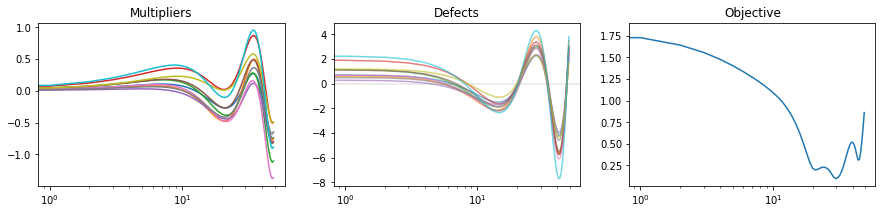

In [35]:
all_metrics = state_history.unpack_stored_metrics()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]))
ax0.set_title("Multipliers")

ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]), alpha=0.6)
ax1.axhline(0.0, c="gray", alpha=0.2)
ax1.set_title("Defects")

ax2.plot(all_metrics["iters"], all_metrics["loss"])
ax2.set_title("Objective")

[_.semilogx() for _ in (ax0, ax1, ax2)]
plt.show()

In [3]:
cmp = MaximumEntropy(mean_constraint=4.5)
formulation = cooper.LagrangianFormulation(cmp)

probs = torch.nn.Parameter(torch.rand(6))

primal_optimizer = cooper.optim.ExtraSGD([probs], lr=3e-2, momentum=0.7)
dual_optimizer = cooper.optim.partial_optimizer(
    cooper.optim.ExtraSGD, lr=9e-3, momentum=0.7
    )

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [4]:
state_history = cooper.StateLogger(save_metrics=["loss", "eq_defect", "eq_multipliers"])

for iter_num in range(5000):

    coop.zero_grad()
    lagrangian = formulation.composite_objective(cmp.closure, probs)
    formulation.custom_backward(lagrangian)
    coop.step(cmp.closure, probs)

    # Store optimization metrics at each step
    partial_dict = {"params": copy.deepcopy(probs.data)}
    state_history.store_metrics(formulation, iter_num, partial_dict)

print(cmp.state)

CMPState(loss=tensor(-1.6136, grad_fn=<SumBackward0>), ineq_defect=tensor([-0.0544, -0.0788, -0.1142, -0.1654, -0.2398, -0.3475],
       grad_fn=<NegBackward0>), eq_defect=tensor([3.6955e-06, 0.0000e+00], grad_fn=<StackBackward0>), proxy_ineq_defect=None, proxy_eq_defect=None, misc=None)


In [5]:
# True solution for mean=4.5
a = torch.tensor([0.05435, 0.07877, 0.1142, 0.1654, 0.2398, 0.3475])
-torch.sum(a * torch.log(a))

tensor(1.6136)

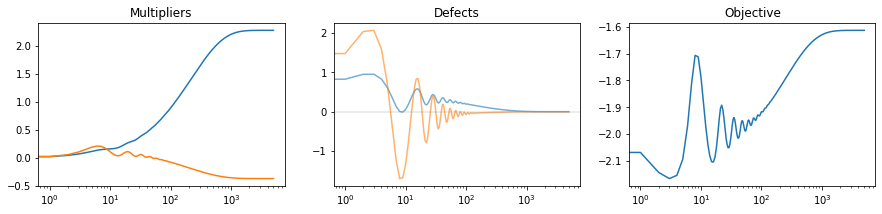

In [6]:
all_metrics = state_history.unpack_stored_metrics()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(15, 3))

ax0.plot(all_metrics["iters"], np.stack(all_metrics["eq_multipliers"]))
ax0.set_title("Multipliers")

ax1.plot(all_metrics["iters"], np.stack(all_metrics["eq_defect"]), alpha=0.6)
ax1.axhline(0.0, c="gray", alpha=0.2)
ax1.set_title("Defects")

ax2.plot(all_metrics["iters"], all_metrics["loss"])
ax2.set_title("Objective")

[_.semilogx() for _ in (ax0, ax1, ax2)]
plt.show()